# Problem:  Predicting remaining useful life for Turbofan engines 

### Introduction

In many real life situations, you will encounter where you do not have labeled data and still you need to detect anomalous activites. This technique walks you through how to learn features, build a model using unlabeled dataset.  We will start by converting to problem from an unsupervised learning problem to a supervised learning problem.

The data for this notebook comes from a well known NASA competition in 2008. The dataset was generated via simulation using C-MAPSS. Four different sets simulated under different combinations of operational conditions and fault modes. Recording several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.  We will use this dataset to learn the behavior of a normal engine.  

### Background

<img src="https://aws-machine-learning-immersion-day.s3.amazonaws.com/resources/engine_failure.gif" width="600" align="center">
<p style="text-align: center;">fan blade containment failure test</p>


Predictive maintenance is important for safety systems and systems where unexpected maintenace and downtime impacts the business objectives.  A turbofan engine is both a safety system and one where unexpected downtime impacts the operation of the airline.  

For predictive maintenance there are typically 3 approaches, it depends on how much you know about the failures and systems: 
1. Similarity - Use this approach if your data captures degridation from the healthy state to the failed state.  
2. Survival - Use this approach when you only have data from the failure event.
3. Degradation - Use this approach when you want the operation of the machine to operate above some limit threshold.

### Contact

* Aaron Sengstacken
* awsaaron@amazon.com

### References
* [Predictive Maintenance - wikipedia](https://en.wikipedia.org/wiki/Predictive_maintenance)
* A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA
* https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/


In [1]:
# Import Libraries
%matplotlib inline

# general python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import io
import os

# sklearn
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score,accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_curve,cohen_kappa_score
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

# aws
import boto3
import sagemaker
from sagemaker import KMeans
from sagemaker import get_execution_role
import sagemaker.amazon.common as smac
from sagemaker.tensorflow import TensorFlow

# tensorflow
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.models import Model

RANDOM_SEED = 1234 #used to help randomly select the data points
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

Using TensorFlow backend.


# Data

The data for this notebook comes from a well known NASA competition in 2008.  The dataset was generated via simulation using C-MAPSS. Four different sets simulated under different combinations of operational conditions and fault modes. Recording several sensor channels to characterize fault evolution. The data set was provided by the Prognostics CoE at NASA Ames.

The dataset consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

### Load Data

In [3]:
# download data from URL
!wget https://ti.arc.nasa.gov/c/6/ -O CMAPSSData.zip

--2021-01-28 19:17:32--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-01-28 19:17:33--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘CMAPSSData.zip’

CMAPSSData.zip      100%[===================>]  11.85M  9.57MB/s    in 1.2s    

2021-01-28 19:17:34 (9.57 MB/s) - ‘CMAPSSData.zip’ saved [12425978/12425978]



In [5]:
# unpack zip file
!unzip -o CMAPSSData.zip

Archive:  CMAPSSData.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt           
  inflating: RUL_FD004.txt           
  inflating: test_FD001.txt          
  inflating: test_FD002.txt          
  inflating: test_FD003.txt          
  inflating: test_FD004.txt          
  inflating: train_FD001.txt         
  inflating: train_FD002.txt         
  inflating: train_FD003.txt         
  inflating: train_FD004.txt         


In [6]:
role = get_execution_role()
session = sagemaker.session.Session()
bucket_name = session.default_bucket()
bucket = 's3://{}'.format(session.default_bucket())
print('default_s3_bucket: {}'.format(bucket))

default_s3_bucket: s3://sagemaker-us-east-1-431615879134


The datasets don't contain any headers so we'll have to manually define those

In [7]:
cols=["unit","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19","sensor20","sensor21","sensor22","sensor23"]

In [8]:
train_df = pd.read_csv('train_FD001.txt',sep=' ',header=None,names=cols)
rul_df = pd.read_csv('RUL_FD001.txt',header=None,names=['rul'])

In [9]:
print('Training Data')
display(train_df.head())
print('Remaining Useful Life Data')
display(rul_df.head())

Training Data


,unit,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


Remaining Useful Life Data


,rul
0,112
1,98
2,69
3,82
4,91


In [10]:
print('Training Data')
print(train_df.shape)
print('Remaining Useful Life Data')
print(rul_df.shape)

Training Data
(20631, 28)
Remaining Useful Life Data
(100, 1)


In [11]:
train_df['remaining_cycles']=train_df.groupby('unit')['cycle'].transform(max)-train_df['cycle']

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   unit              20631 non-null  int64  
 1   cycle             20631 non-null  int64  
 2   op1               20631 non-null  float64
 3   op2               20631 non-null  float64
 4   op3               20631 non-null  float64
 5   sensor1           20631 non-null  float64
 6   sensor2           20631 non-null  float64
 7   sensor3           20631 non-null  float64
 8   sensor4           20631 non-null  float64
 9   sensor5           20631 non-null  float64
 10  sensor6           20631 non-null  float64
 11  sensor7           20631 non-null  float64
 12  sensor8           20631 non-null  float64
 13  sensor9           20631 non-null  float64
 14  sensor10          20631 non-null  float64
 15  sensor11          20631 non-null  float64
 16  sensor12          20631 non-null  float6

**Take Away:** Data was loaded successfully, we have some null values in the last two sensors that we'll need to address

### Data Exploration and Preparation

**Questions:**

1. How many engines are in the dataset?
2. How long was each engine run?
3. What is the distribution of total cycles on each engine?
4. What are the operational settings for the engines and how do they vary?

In [13]:
# Question 1 - How many engines are in the dataset?
train_df['unit'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [14]:
# Question 2 - How long was each engine run for?
max_cycles = train_df.groupby('unit')['cycle'].max()

(0, 101)

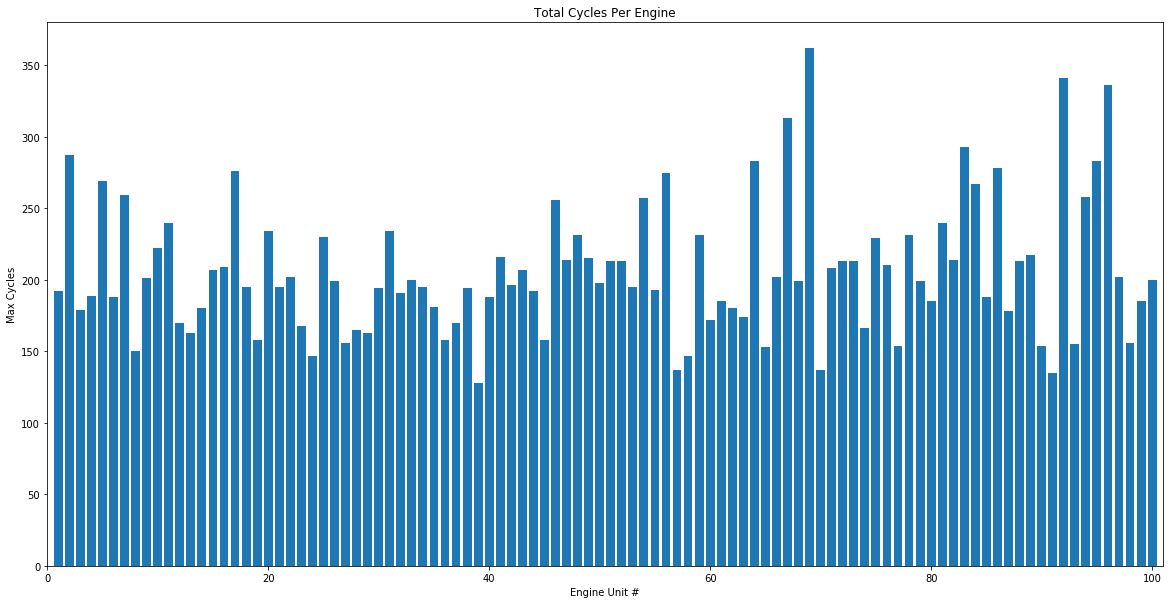

In [15]:
fig,ax = plt.subplots(figsize=(20,10))
plt.bar(max_cycles.index,max_cycles.values)
plt.xlabel('Engine Unit #')
plt.ylabel('Max Cycles')
plt.title('Total Cycles Per Engine')
plt.xlim((0,101))

Text(0, 0.5, 'Count')

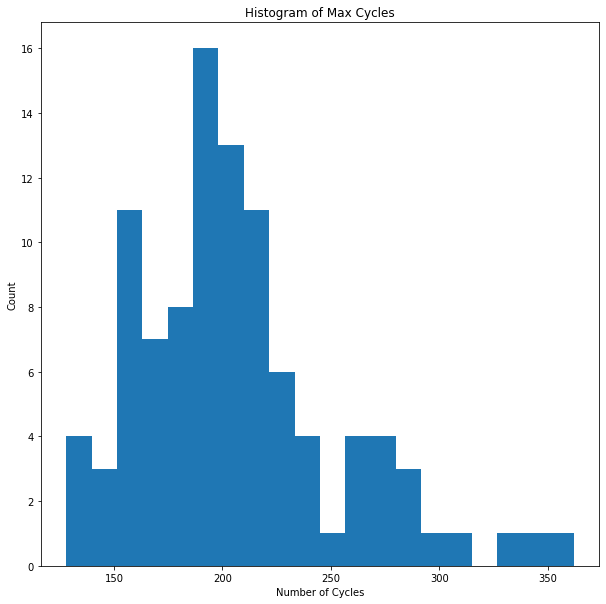

In [16]:
# Question 3 - What is the distribution of cycles across engines?
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(max_cycles.values,bins=20)
plt.title('Histogram of Max Cycles')
plt.xlabel('Number of Cycles')
plt.ylabel('Count')

In [17]:
max_cycles.describe()

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

count    20631.000000
mean        -0.000009
std          0.002187
min         -0.008700
25%         -0.001500
50%          0.000000
75%          0.001500
max          0.008700
Name: op1, dtype: float64

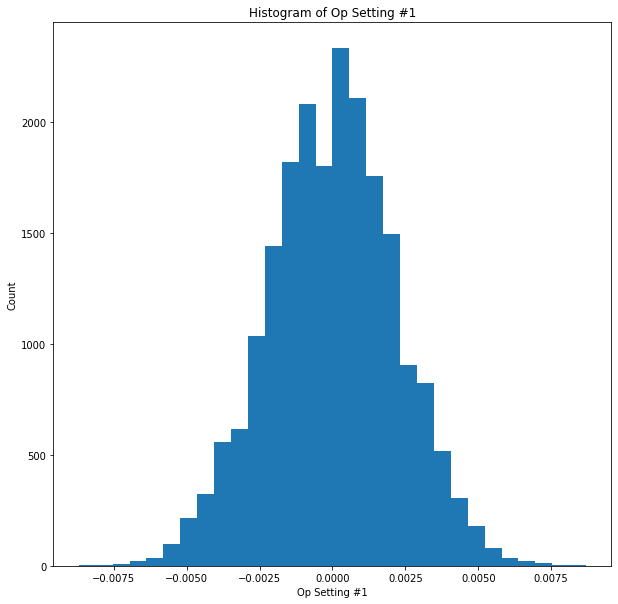

In [18]:
#Question 4. What are the operational settings for the engines and how do they vary?
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op1'].values,bins=30)
plt.title('Histogram of Op Setting #1')
plt.xlabel('Op Setting #1')
plt.ylabel('Count')
train_df['op1'].describe()

count    20631.000000
mean         0.000002
std          0.000293
min         -0.000600
25%         -0.000200
50%          0.000000
75%          0.000300
max          0.000600
Name: op2, dtype: float64

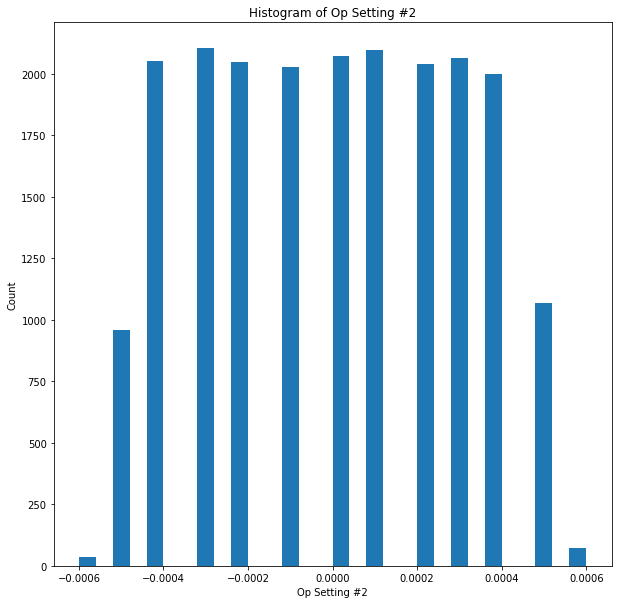

In [19]:
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op2'].values,bins=30)
plt.title('Histogram of Op Setting #2')
plt.xlabel('Op Setting #2')
plt.ylabel('Count')
train_df['op2'].describe()

count    20631.0
mean       100.0
std          0.0
min        100.0
25%        100.0
50%        100.0
75%        100.0
max        100.0
Name: op3, dtype: float64

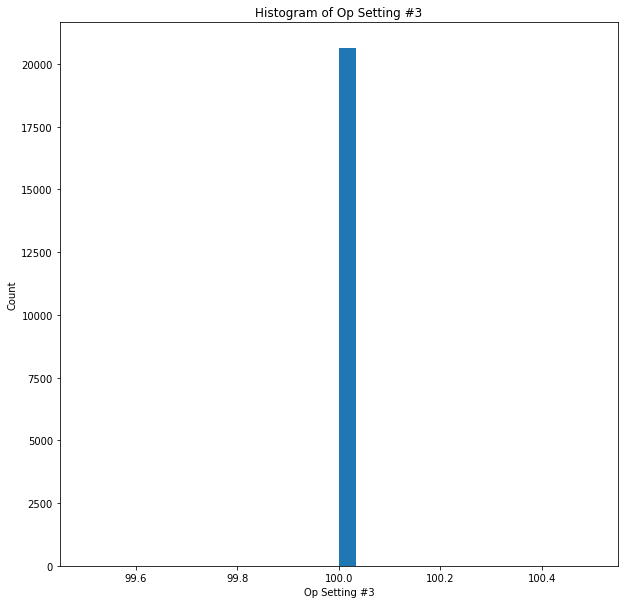

In [20]:
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(train_df['op3'].values,bins=30)
plt.title('Histogram of Op Setting #3')
plt.xlabel('Op Setting #3')
plt.ylabel('Count')
train_df['op3'].describe()

**Take Away** The Op3 setting is constant for all data in the dataset, suggest removal

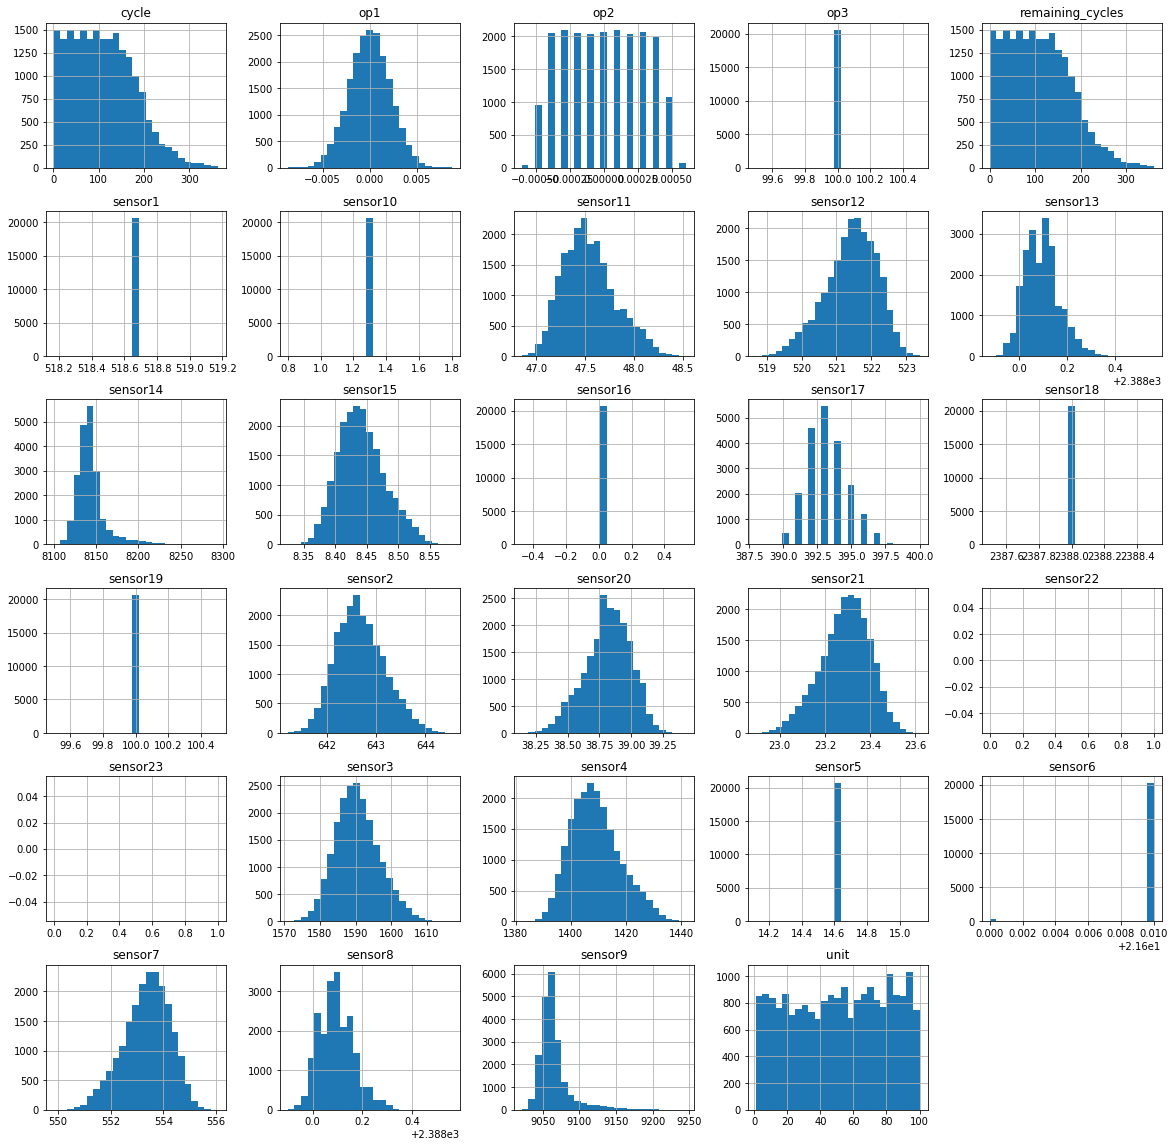

In [23]:
train_df.hist(figsize=(20,20),bins=25);

In [24]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
op1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
op2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
op3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
sensor1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
sensor2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
sensor3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
sensor4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
sensor5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


**Take Away** 
1. Sensor 1, 5, 6, 10, 16, 18, 19, Op3 have constant values across the dataset, suggest removal.  
2. Sensor 22, 23 are missing, suggest removal

Note:  Unit and Cycle histograms are not informative since they contain the engine number and cycle (recall from above that max cycle per engine was useful)

In [25]:
drop_cols = ['unit','cycle','op3','sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19','sensor22','sensor23']

In [26]:
train_df.drop(drop_cols,axis=1,inplace=True)

#### Prepare Target Variable

For this task we want to predict that the engine is near failure, before it fails.  To do that we will convert the cycle count column to remaining cycles.  Next, we will add an additonal column that is a binary variable when the engine has X remaining cycles left.  X can be defined by the user.  In this example we will use 40 remaining cycles as the 

In [61]:
cycle_limit = 40
train_df['failed'] = train_df['remaining_cycles'].apply(lambda x: 1 if x <= cycle_limit else 0)

In [62]:
print('Total number of failed cases in training dataset:  '+str(train_df['failed'].sum()))
print('Fraction of total in training dataset:  '+str(train_df['failed'].sum()/train_df['failed'].count()))

Total number of failed cases in training dataset:  4100
Fraction of total in training dataset:  0.19873006640492463


#### Missing Values

In [63]:
train_df.isnull().values.any()

False

In [64]:
print('Training Dataset Shape:', train_df.shape)

Training Dataset Shape: (20631, 18)


In [65]:
train_df.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21,remaining_cycles,failed
0,0.0019,0.0002,642.58,1586.81,1397.25,553.96,2388.07,9066.89,47.22,522.35,2388.00,8140.88,8.4223,393,38.96,23.3780,169,0
1,0.0001,0.0001,643.20,1591.64,1410.92,552.21,2388.19,9055.31,47.74,520.48,2388.15,8137.26,8.4588,393,38.70,23.1894,112,0
2,-0.0032,0.0004,642.12,1587.96,1394.48,554.26,2388.01,9060.24,47.31,522.53,2388.03,8151.48,8.4488,393,38.96,23.3425,151,0
3,-0.0001,-0.0003,642.60,1590.32,1410.63,553.04,2388.11,9058.24,47.40,521.58,2388.09,8139.22,8.4359,394,38.89,23.3002,89,0
4,0.0003,-0.0002,642.71,1593.85,1409.66,552.72,2388.12,9061.56,47.64,521.37,2388.06,8141.76,8.4357,394,38.71,23.1922,87,0


#### Save off the datasets

In [66]:
train_df.to_csv('cleaned_train.csv',index=False)

#### OPTIONAL - Load the saved datasets

In [67]:
train_df = pd.read_csv('cleaned_train.csv')

#### Shuffle / Randomize

In [68]:
train_df = train_df.sample(frac=1,random_state=RANDOM_SEED).reset_index(drop=True)

#### Select only non-failed rows and drop other columns

In [69]:
train_x = train_df.loc[train_df['failed'] == 0]
train_x = train_x.drop(['failed','remaining_cycles'], axis=1)

In [70]:
train_x.head()

,op1,op2,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor11,sensor12,sensor13,sensor14,sensor15,sensor17,sensor20,sensor21
0,-0.0038,-0.0005,642.62,1593.51,1410.15,553.41,2388.04,9067.71,47.47,521.97,2388.07,8153.14,8.4286,393,38.86,23.3528
1,-0.0029,-0.0004,642.29,1589.45,1399.39,554.32,2388.06,9057.61,47.40,521.90,2388.01,8142.27,8.4399,392,38.85,23.3294
2,0.0023,0.0003,642.73,1585.04,1409.85,553.99,2388.04,9066.22,47.42,521.59,2388.09,8144.49,8.4151,392,39.19,23.3992
3,0.0020,0.0001,642.84,1587.37,1403.40,553.55,2388.12,9065.87,47.59,521.10,2388.07,8143.06,8.4479,392,38.79,23.3209
4,0.0012,-0.0001,642.70,1590.64,1400.06,553.23,2388.06,9049.68,47.48,521.19,2388.12,8124.27,8.4403,392,38.86,23.2026


#### Split Dataset

In [71]:
# 80% for the training set and 20% for testing set
TEST_PCT = 0.2 # 20% of the data
train_x, val_x = train_test_split(train_x, test_size=TEST_PCT, random_state=RANDOM_SEED)

#### Scale Data

IMPORTANT! - You must apply the same scaling from the training dataset to the testing / validation dataset

In [125]:
scaler = MinMaxScaler()
scaler = RobustScaler()

In [126]:
scaler.fit(train_x)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [127]:
train = scaler.transform(train_x)
val = scaler.transform(val_x)

#### Save and Upload Data

In [128]:
os.makedirs("./data", exist_ok = True)

# save
with open('./data/val.npy', 'wb') as f: np.save(f, val)
with open('./data/train.npy', 'wb') as f: np.save(f, train)

In [129]:
# load
with open('./data/val.npy', 'rb') as f: val = np.load(f)
with open('./data/train.npy', 'rb') as f: train = np.load(f)

In [130]:
prefix = 'turbofan-RUL-AE'

training_input_path   = sess.upload_data('data/train.npy', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/val.npy', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-1-431615879134/turbofan-RUL-AE/training/train.npy
s3://sagemaker-us-east-1-431615879134/turbofan-RUL-AE/validation/val.npy


# Model Training

AutoEncoders are special kind of neural networks, where your input is 'x' and you have your output as 'x' as well. What this really means is that we are trying to learn a function, where the input and output are the same.

AutoEncoders are special kind of neural networks, where your input is 'x' and you have your output as 'x' as well. What this really means is that we are trying to learn a function, where the input and output are the same.

The function f(x), that we are going to learn is approximately equal to x 

![](Autoencoder_structure.png)

Few things to note. 

- We are reducing the number of nodes, which will force network to learn the features from the dataset. Intuition being that this "code" is a set of abstracted features which represents or creates a fingerprint for "failures" or a "non-failure" activitiy.
- Since we are starting with the input 'x', reducing into a abstracted features and then reconstructing back the 'x' means we really don't need a labeled dataset. 
- The "code" is intutively a representation of abstracted features. 

For our engine dataset, we are going to get all the non-failed data and will try to re-create the same. During this process the network should try to learn a unique representation of what's a non-failed activity. Once the model is trained with whats 'normal' that means anything which does not match this normal representation can be declared as abnormal. 

For inference, we are going to give both failed and non-failed data to the model. Model prediction will give us the  reconstruction error. This is where we set the threshold which let's domain expert define what tolerance is ok consider normal and when to declare as abnormal data. 

In [268]:
!pygmentize turbofan_autoencoder_keras_tf.py

import argparse, os
import numpy as np

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Input
from keras import regularizers
from keras.optimizers import Adam
from keras.utils import multi_gpu_model

if __name__ == '__main__':
        
    ## INPUT ARGUMENTS
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=128)
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])
    
    args, _ = parser.parse_known_args()
    
    epochs    

## Train with Tensorflow on the notebook instance (aka 'local mode')

In [111]:
tf_estimator = TensorFlow(entry_point='turbofan_autoencoder_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='local',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 2}
                         )

In [80]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

Creating tmp0ptsrrcd_algo-1-6rple_1 ... 
Attaching to tmp0ptsrrcd_algo-1-6rple_12mdone
algo-1-6rple_1  | 2021-01-28 20:21:09,221 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-6rple_1  | 2021-01-28 20:21:09,226 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6rple_1  | 2021-01-28 20:21:09,409 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6rple_1  | 2021-01-28 20:21:09,423 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-6rple_1  | 2021-01-28 20:21:09,434 sagemaker-containers INFO     Invoking user script
algo-1-6rple_1  | 
algo-1-6rple_1  | Training Env:
algo-1-6rple_1  | 
algo-1-6rple_1  | {
algo-1-6rple_1  |     "additional_framework_parameters": {},
algo-1-6rple_1  |     "channel_input_dirs": {
algo-1-6rple_1  |         "training": "/opt/ml/input/data/training",
algo-1-6rple_1  |         "validation": "/opt/ml/input/data/valida

## Train with Tensorflow on a GPU instance

In [271]:
tf_estimator = TensorFlow(entry_point='turbofan_autoencoder_keras_tf.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.m5.xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 50,
                              'batch-size': 128,
                              'learning-rate': 0.001}
                         )

In [272]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2021-01-28 22:05:09 Starting - Starting the training job...
2021-01-28 22:05:32 Starting - Launching requested ML instancesProfilerReport-1611871508: InProgress
......
2021-01-28 22:06:33 Starting - Preparing the instances for training...
2021-01-28 22:06:59 Downloading - Downloading input data...
2021-01-28 22:07:34 Training - Training image download completed. Training in progress.2021-01-28 22:07:27,950 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-01-28 22:07:27,956 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-28 22:07:56,543 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-28 22:07:56,558 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-01-28 22:07:56,568 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input

### Model Training Performance

#### Training Evaluation

In [273]:
# plot validation and training progress
client = boto3.client('logs')
BASE_LOG_NAME = '/aws/sagemaker/TrainingJobs'

def plot_log(model):
    logs = client.describe_log_streams(logGroupName=BASE_LOG_NAME, logStreamNamePrefix=model._current_job_name)
    cw_log = client.get_log_events(logGroupName=BASE_LOG_NAME, logStreamName=logs['logStreams'][0]['logStreamName'])

    val = []
    train = []
    iteration = []
    count = 0
    for e in cw_log['events']:
        msg = e['message']
        if '/step' in msg:
            msg = msg.split(' ')
            #print(msg)
            train.append(float(msg[-4]))
            val.append(float(msg[-1]))
            iteration.append(count)
            count+=1

    fig, ax = plt.subplots(figsize=(15,10))
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    train_plot,   = ax.plot(iteration,   train,   label='train')
    val_plot,   = ax.plot(iteration,   val,   label='validation')
    plt.legend(handles=[train_plot,val_plot])
    plt.grid()
    plt.show()

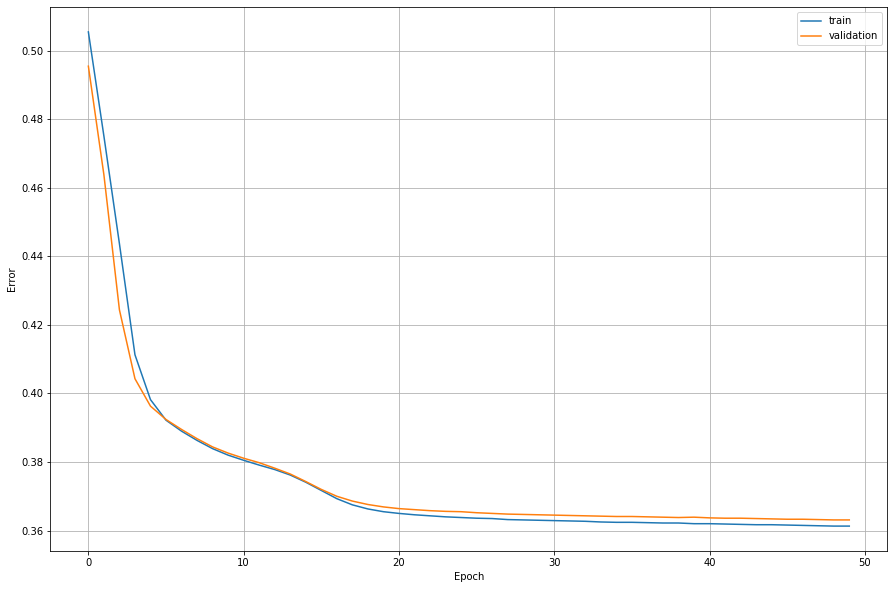

In [274]:
plot_log(tf_estimator)

# Deploy

### Deploy the trained model with Elastic Inference and Data Capture

Pricing for SageMaker by region is found [here](https://aws.amazon.com/sagemaker/pricing/)

In [275]:
%%time

import time
from sagemaker.model_monitor import DataCaptureConfig

tf_endpoint_name = 'turbo-fan-RUL-AE-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
s3_capture_upload_path = 's3://{}/{}/monitoring/datacapture'.format(bucket_name, prefix)
print(s3_capture_upload_path)

#predictor = tf_estimator.deploy(initial_instance_count=1,
#                                   instance_type='ml.p2.xlarge')      # $1.125/hour in us-east-1

predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.c5.large',        # $0.119/hour in us-east-1
                         accelerator_type='ml.eia1.medium',  # + $0.168/hour in us-east-1
                         endpoint_name=tf_endpoint_name,     # = 67% discount!
                         data_capture_config=DataCaptureConfig(
                                enable_capture=True,
                                sampling_percentage=100,
                                destination_s3_uri=s3_capture_upload_path))

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


s3://sagemaker-us-east-1-431615879134/turbofan-RUL-AE/monitoring/datacapture
-------------!CPU times: user 217 ms, sys: 9.67 ms, total: 226 ms
Wall time: 6min 32s


### OPTIONAL - Connect to deployed endpoint

In [ ]:
# How do you connect to an already deployed endpoint
end_point_name = 'ENDPOINT-NAME'
predictor = sagemaker.tensorflow.model.TensorFlowPredictor(end_point_name,sagemaker_session=sess)

# Predict

We are going to calculate the mean squared error between predicted and the expected values. This will be our reconstruction error

In [276]:
# single predictions
test1 = np.array([ 0.23181664, -1.031415  ,  0.0200345 ,  0.49338209,  1.00451033,
       -1.45819216,  0.0041503 ,  0.03854353,  0.54958493, -0.95076123,
        0.16660914, -0.18772613,  0.64182997,  0.67217714, -0.82575155,
       -0.16161417])

result = predictor.predict(test1)
print(result)

test2 = np.array([ 1.05574627,  1.35571432, -0.57110458,  0.74633819,  0.67483162,
       -0.51925459,  0.77610555, -0.76845284, -0.2522413 , -0.04313786,
        0.31915843, -0.43000929,  0.683185  ,  0.67217714,  0.20974389,
        0.09380091])

result = predictor.predict(test2)
print(result)

{'predictions': [[0.0896591, 0.0, 0.0, 0.0, 0.613879, 0.0, 0.493838, 0.0318632, 0.0, 0.0, 0.497426, 0.0, 0.748817, 0.320855, 0.0, 0.0]]}
{'predictions': [[1.07161, 0.0, 0.0, 0.0, 0.616567, 0.0, 0.619245, 0.0, 0.0, 0.0, 0.592024, 0.0, 0.789263, 0.307001, 0.0, 0.0]]}


Now let's list the data capture files stored in S3. You should expect to see different files from different time periods organized based on the hour in which the invocation occurred.

**Note that the delivery of capture data to Amazon S3 can require a couple of minutes so next cell might error. If this happens, please retry after a minute.**

In [279]:
s3_client = boto3.Session().client('s3')
current_endpoint_capture_prefix = '{}/monitoring/datacapture/{}'.format(prefix, tf_endpoint_name)

result = s3_client.list_objects(Bucket=bucket_name, Prefix=current_endpoint_capture_prefix)
capture_files = ['s3://{0}/{1}'.format(bucket_name, capture_file.get("Key")) for capture_file in result.get('Contents')]

print("Capture Files: ")
print("\n ".join(capture_files))

TypeError: 'NoneType' object is not iterable

We can also read the contents of one of these files and see how capture records are organized in JSON lines format.

In [280]:
!aws s3 cp {capture_files[0]} datacapture/captured_data_example.jsonl

import json
with open ("datacapture/captured_data_example.jsonl", "r") as myfile:
    data=myfile.read()

print(json.dumps(json.loads(data.split('\n')[0]), indent=2))

download: s3://sagemaker-us-east-1-431615879134/turbofan-RUL-AE/monitoring/datacapture/turbo-fan-RUL-AE-2021-01-28-20-03-50/AllTraffic/2021/01/28/20/11-33-222-ca890ac8-e727-47d6-a23f-a605371aa131.jsonl to datacapture/captured_data_example.jsonl
{
  "captureData": {
    "endpointInput": {
      "observedContentType": "application/json",
      "mode": "INPUT",
      "data": "[0.23181664, -1.031415, 0.0200345, 0.49338209, 1.00451033, -1.45819216, 0.0041503, 0.03854353, 0.54958493, -0.95076123, 0.16660914, -0.18772613, 0.64182997, 0.67217714, -0.82575155, -0.16161417]",
      "encoding": "JSON"
    },
    "endpointOutput": {
      "observedContentType": "application/json",
      "mode": "OUTPUT",
      "data": "{\n    \"predictions\": [[-0.254027, -0.669781, 0.512843, 0.537859, 0.587814, -0.615441, 0.623188, 0.107272, 0.667016, -0.694629, 0.635556, -0.000644535, 0.561718, 0.463547, -0.555277, -0.592368]\n    ]\n}",
      "encoding": "JSON"
    }
  },
  "eventMetadata": {
    "eventId": "82

For each inference request, we get input data, output data and some metadata like the inference time captured and saved.


#### Reconstruction error without failure

In [281]:
# run the validation data through the trained model
y_pred_val = predictor.predict(val)['predictions']
mse = np.mean(np.power(val - y_pred_val, 2), axis=1)

In [282]:
error_df_val = pd.DataFrame({'reconstruction_error': mse,'true_class': np.zeros(len(mse))})
error_df_val.describe(percentiles=[.50,.90,.95,.99,.999,.9999])

,reconstruction_error,true_class
count,3307.000000,3307.0
mean,0.363055,0.0
std,0.207950,0.0
min,0.038049,0.0
50%,0.313674,0.0
90%,0.645925,0.0
95%,0.778551,0.0
99%,1.002748,0.0
99.9%,1.376157,0.0
99.99%,1.642833,0.0


#### Reconstruction error with failure

In [283]:
# run the failed examples through the trained model
train_fail = train_df.loc[train_df['failed'] == 1]
train_fail = train_fail.drop(['failed','remaining_cycles'], axis=1)
train_fail_scaled = scaler.transform(train_fail)

In [284]:
y_pred = predictor.predict(train_fail_scaled)['predictions']
mse = np.mean(np.power(train_fail_scaled - y_pred, 2), axis=1)

error_df_val_fail = pd.DataFrame({'reconstruction_error': mse,'true_class': np.ones(len(mse))})
error_df_val_fail.describe(percentiles=[.50,.90,.95,.99,.999,.9999])

,reconstruction_error,true_class
count,4100.000000,4100.0
mean,1.195429,1.0
std,0.674773,0.0
min,0.090120,1.0
50%,1.082593,1.0
90%,2.142667,1.0
95%,2.432150,1.0
99%,2.940895,1.0
99.9%,4.161656,1.0
99.99%,5.804956,1.0


In [285]:
val_df = pd.concat([error_df_val,error_df_val_fail],ignore_index=True,axis=0)

Text(0, 0.5, 'normalized count')

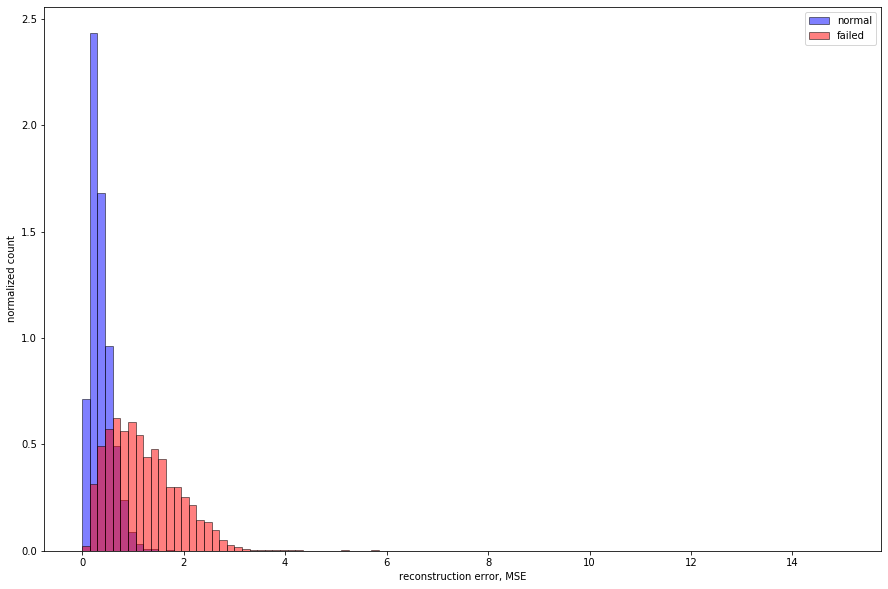

In [286]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
_ = ax.hist(val_df[val_df['true_class']==0]['reconstruction_error'].values, bins=100, range=(0,15),density=True,color='blue',edgecolor='black',alpha=0.5,label='normal')
_ = ax.hist(val_df[val_df['true_class']==1]['reconstruction_error'], bins=100, range=(0,15),density=True,color='red',edgecolor='black',alpha=0.5,label='failed')
plt.legend()
plt.xlabel('reconstruction error, MSE')
plt.ylabel('normalized count')

### Evaluation

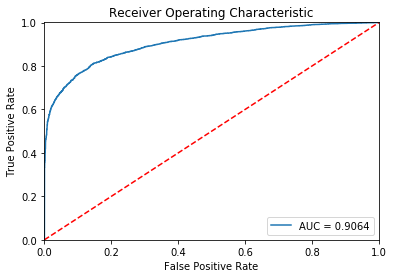

In [287]:
fpr, tpr, thresholds = roc_curve(val_df.true_class, val_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

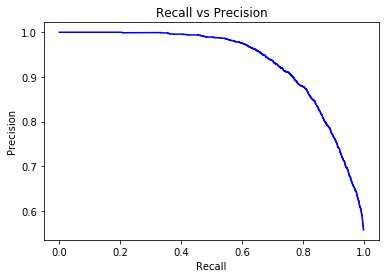

In [288]:
precision, recall, th = precision_recall_curve(val_df.true_class, val_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

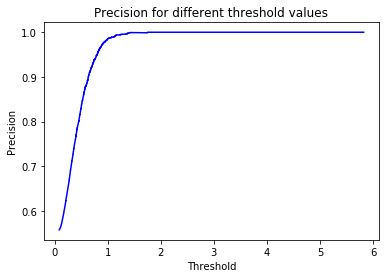

In [289]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

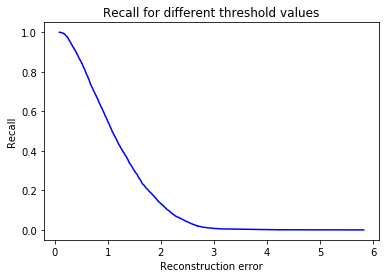

In [290]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [291]:
threshold = 0.9

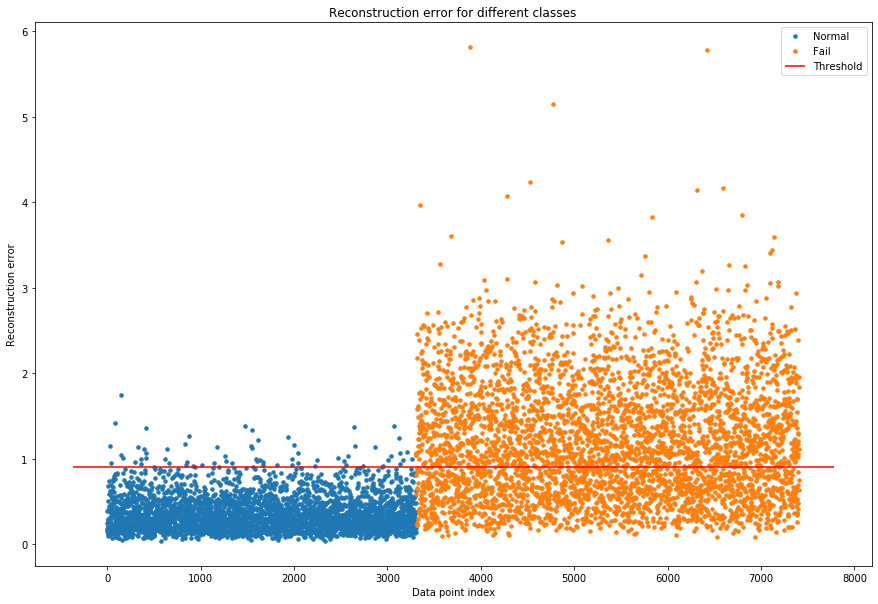

In [292]:
groups = val_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15,10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fail" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [293]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [294]:
# define thresholds
thresholds = np.arange(0, 2, 0.001)
# evaluate each threshold
scores = [f1_score(val_df['true_class'], to_labels(val_df.reconstruction_error, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.522, F-Score=0.84298


In [295]:
t = 0.522
pd.crosstab(index=val_df['true_class'], columns=to_labels(val_df.reconstruction_error,t), rownames=['actuals'], colnames=['predictions'])

predictions,0,1
actuals,,
0.0,2680,627
1.0,656,3444


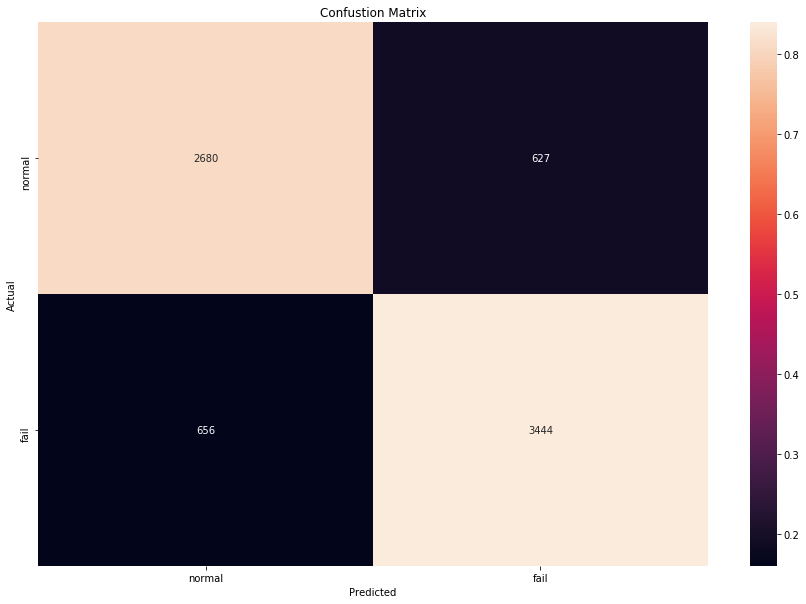

In [297]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from IPython.display import display, clear_output

class_list = ['normal','fail']
fig, ax = plt.subplots(figsize=(15,10))
cm = confusion_matrix(val_df['true_class'],to_labels(val_df.reconstruction_error,t))
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confustion Matrix')
plt.show()

# Clean Up

If you are done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
predictor.delete_endpoint()